Short Term Rental Daily Rates

This notebook creates a regression model to predict (or recommend) a daily rental rate based on various features of a property and then saves it as pickle file for reuse. The model is based on about 2000 records of short term rentals for a single zip code that was downloaded from the website AllTheRooms (via personal paid subscription).

Some downsides:

1 - The accuracy is not as good I'd like due to not having more data. This is mostly due to limitations placed on the amount of source data that can be downloaded from the website.

2 - The amenities increase accuracy but do not affect the final rates predicted by the model. You can expect higher number of bedrooms or full homes (vs. apartments) demanding higher prices but amenities such as pools or exercise facilities should cause some variation as well in my opinion. The model currently does not predict any changes regardless of amenities. This may be due to the limitations mentioned above or it may simply be due to the large number of rentals that have this amenity (I have yet to fully analyze the data to see if my source data has enough properties with varying amenities).

Disclaimer:
AllTheRooms requires a paid subscription in order to download raw data. You will need to have your own subscription to use this model as-is.


In [1]:
# Import all needed libraries

import pandas as pd
import numpy as np
import joblib
import glob
import csv
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline


Each CSV file can only hold 1000 records due to the website limitations. The next snippet will merge them all. The rates are also separate from the property details so they need to be joined later via UID.


In [2]:
# Prep for merging airbnb details (studios, 2/2, 5bed, 5/4)
joined_files = os.path.join("AllTheRoomsData/", "*details.csv")
joined_stats = os.path.join("AllTheRoomsData/", "*stats.csv")

joined_list = glob.glob(joined_files)
joined_stats = glob.glob(joined_stats)

# Merge the files and verify
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)
df.head()

,UID,Listing URL,Listing Title,Property Type,Arrangement Type,Longitude,Latitude,City,Currency Local,Bedrooms,Bathrooms,Max Guests,Overall Rating,Pets Allowed,Amenities,Security Deposit (USD),Created Date,Number of Reviews,Number of Photos
0,12382448,https://www.airbnb.com/rooms/12382448,"Lovely 2/2, WATER PARK! 2mi to Disney, Sanitized!",condo,Entire Home,-81.59376,28.32352,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,cable tv,chi...",100.0,2016-07-09,174,54
1,12433858,https://www.airbnb.com/rooms/12433858,REMODELED Windsor Hills Condo 2 Miles 2 Disney,condo,Entire Home,-81.59296,28.32437,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,bathtub,cabl...",200.0,2016-07-09,39,62
2,12812645,https://www.airbnb.com/rooms/12812645,Westgate Town Center sleeps 8pp,apartment,Entire Home,-81.59498,28.32955,NaN,NaN,2,2,8,NaN,No,"air conditioning,dryer,elevator,essentials,fam...",NaN,2016-07-11,1,33
3,13623622,https://www.airbnb.com/rooms/13623622,2 Bedroom Villa Available for Rent! Floating Unit,villa,Entire Home,-81.59512,28.33150,NaN,NaN,2,2,8,NaN,No,"air conditioning,cable tv,dryer,essentials,fam...",100.0,2016-07-09,1,5
4,14121078,https://www.airbnb.com/rooms/14121078,3 mi to Disney!*Spacious 2BR/2BA+Loft Resort C...,condo,Entire Home,-81.48591,28.33744,NaN,NaN,2,2,6,100.0,No,"24 hour check in,air conditioning,bathtub,bedr...",0.0,2016-07-21,118,66



The amenities are listed as a comma separated string value. We need to do some feature engineering by parsing these values and then adding them as columns to the dataframe.


In [3]:
#Parse through amenities and create a list of values to add as features
amenity_ls_str = ""
for prop_amenities in df["Amenities"]:
    ls = prop_amenities.split(",")
    for i in ls:
        amenity_ls_str = amenity_ls_str + "," + i

amenity_ls = (list(set(amenity_ls_str.split(","))))
amenity_ls.remove("")

In [4]:
#Verify amenity list to ensure no nulls or duplicates
print(amenity_ls)

['long term stays', 'breakfast included', 'fireplace', 'dryer', 'pool', 'smoke alarm', 'hot water', 'coffee', 'parking', 'living area', 'netflix', 'books', 'patio or balcony', 'family friendly', 'hangers', 'air conditioning', 'dishwasher', 'in home entertainment', 'cleaning included', 'ice machine', 'sports court', 'blender', 'fitness and wellbeing', 'waterfront', 'bathroom essentials', 'fire extinguisher', 'bathtub', 'garbage disposal', 'workspace', 'heating', 'essentials', 'music', 'ski friendly', 'cleanliness', 'bbq', 'cable tv', 'sauna', 'bedroom essentials', 'fans', 'kitchen essentials', 'hairdryer', 'dining space', 'laundry', 'safety', 'shampoo', 'events allowed', 'outdoor seating', 'bikes', 'water sports', 'hot tub', 'easy access', 'smoking allowed', 'private bathroom', 'child essentials', 'lock on bedroom door', 'host greets you', 'elevator', 'garden', 'luggage dropoff', 'kitchen', 'microwave', 'beach essentials', 'fridge', 'wheelchair friendly', 'ironing', 'first aid kit', 'vi

In [5]:
# Add amenity list as columns to property details dataframe
for a in amenity_ls:
    df[a] = np.nan

# If value in amenities column set new column value to 1, it not set value to 0
for a in amenity_ls:
    df[a].loc[df["Amenities"].str.contains(a)] = True
    
for a in amenity_ls:
    df[a].loc[df[a].isnull()] = False

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



Now that we have all our amenities added to a single dataframe of property details we need to remove irrelevant information. For example, since we know our data is for a single zip code, location data doesn't mean much. We can also reasonably expect that all properties will offer air conditioning.

We also need to make certain assumptions for null data: we will assume an "average" user rating for all properties with no official rating and a zero dollar security deposit where none exists in the data.


In [6]:
# Drop columns that don't make sense for this model or where values don't change
df_lesscolumns = df.drop(columns=["Listing Title", "Arrangement Type", "Longitude", "Latitude", "City", "Currency Local", "Amenities", "Created Date","air conditioning","cleanliness","coffee","hangers","heating","hot water","fans","books","blender","microwave","smoke alarm","ironing","lock on bedroom door","safety","music","garbage disposal","ice machine","shampoo","private bathroom"])

# Impute average rating for null ratings and 0 for null security deposits
meanrating = df_lesscolumns["Overall Rating"].mean()
values = {"Overall Rating": meanrating, "Security Deposit (USD)": 0}
df_clean = df_lesscolumns.fillna(value=values)


Now we will build a single dataframe by combining our property details with our daily rental rates data. Our rates CSV file has an average rate for each month of the year per property but we want a single average in order to join with our other dataframe so we will need to do some math. We will also create some new features based on the occupancy data.

We end up with a single dataframe that we will call rentals_final.

In [7]:
# Start building rental rates dataframe
df_stats = pd.concat(map(pd.read_csv, joined_stats), ignore_index=True)

#Drop rows
df_stats_clean = df_stats.dropna(axis=0)

# Combine the property performance stats with the property details by taking the mean of each metric
rentals = df_clean

rentals["ADR"] = np.nan
rentals["Avg Nights Booked"] = np.nan
rentals["Avg Nights Available"] = np.nan
rentals["Avg Bookings"] = np.nan
rentals["Avg Stay Length"] = np.nan

for num in df_stats_clean["UID"].unique():
    prop = df_stats_clean[df_stats_clean["UID"] == num]
    
    avgrate = prop["ADR"].mean()
    avgbooked = prop["NIGHTS_BOOKED"].mean()
    avgnightsavailable = prop["NIGHTS_AVAILABLE"].mean()
    avgbookings = prop["BOOKING_COUNT"].mean()
    avgstaylength = prop["AVG_LENGTH_OF_STAY"].mean()
    
    rentals["ADR"].mask(rentals["UID"] == num, other=avgrate, inplace=True)
    rentals["Avg Nights Booked"].mask(rentals["UID"] == num, other=avgbooked, inplace=True)
    rentals["Avg Nights Available"].mask(rentals["UID"] == num, other=avgnightsavailable, inplace=True)
    rentals["Avg Bookings"].mask(rentals["UID"] == num, other=avgbookings, inplace=True)
    rentals["Avg Stay Length"].mask(rentals["UID"] == num, other=avgstaylength, inplace=True)
    
# Drop null rows one more time to due inactive listings that don't have bookings or income
rentals_clean = rentals.dropna(axis=0)

# Verify that we got rid of all nulls
print("-- Nulls in Rentals --")
for c in rentals_clean.columns:
    print(c + ": " + str(rentals_clean[c].isnull().sum()))

-- Nulls in Rentals --
UID: 0
Listing URL: 0
Property Type: 0
Bedrooms: 0
Bathrooms: 0
Max Guests: 0
Overall Rating: 0
Pets Allowed: 0
Security Deposit (USD): 0
Number of Reviews: 0
Number of Photos: 0
long term stays: 0
breakfast included: 0
fireplace: 0
dryer: 0
pool: 0
parking: 0
living area: 0
netflix: 0
patio or balcony: 0
family friendly: 0
dishwasher: 0
in home entertainment: 0
cleaning included: 0
sports court: 0
fitness and wellbeing: 0
waterfront: 0
bathroom essentials: 0
fire extinguisher: 0
bathtub: 0
workspace: 0
essentials: 0
ski friendly: 0
bbq: 0
cable tv: 0
sauna: 0
bedroom essentials: 0
kitchen essentials: 0
hairdryer: 0
dining space: 0
laundry: 0
events allowed: 0
outdoor seating: 0
bikes: 0
water sports: 0
hot tub: 0
easy access: 0
smoking allowed: 0
child essentials: 0
host greets you: 0
elevator: 0
garden: 0
luggage dropoff: 0
kitchen: 0
beach essentials: 0
fridge: 0
wheelchair friendly: 0
first aid kit: 0
video game console: 0
24 hour check in: 0
wifi: 0
pet frie

In [8]:
# Remove outliers
q9 = rentals_clean.ADR.quantile(0.9)
rentals_final = rentals_clean.drop(rentals_clean[rentals_clean.ADR>q9].index)

# Combine columns into occupancy feature
rentals_final["Avg Occ"] = rentals_final["Avg Nights Booked"]/rentals_final["Avg Nights Available"]

#Combine columns into turnover rate
rentals_final["Avg Turnover"] = rentals_final["Avg Bookings"]/rentals_final["Avg Stay Length"]
rentals_final = rentals_final.drop(columns=["Avg Nights Booked", "Avg Nights Available", "Avg Bookings", "Avg Stay Length"])
rentals_final.describe()

,UID,Bedrooms,Bathrooms,Max Guests,Overall Rating,Security Deposit (USD),Number of Reviews,Number of Photos,ADR,Avg Occ,Avg Turnover
count,2.161000e+03,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000
mean,1.183943e+15,4.055067,3.444702,9.768163,94.463087,240.380842,29.444239,40.675150,218.303843,0.549919,0.408508
std,2.459215e+16,2.033339,1.475673,3.641126,6.313301,458.307987,39.499821,20.210695,96.054946,0.200344,0.419766
min,1.270590e+05,0.000000,1.000000,2.000000,40.000000,0.000000,0.000000,4.000000,38.666667,0.045977,0.000000
25%,2.946727e+07,2.000000,2.000000,6.000000,90.000000,0.000000,5.000000,27.000000,139.800000,0.409639,0.162500
50%,4.258124e+07,5.000000,4.000000,10.000000,94.646414,100.000000,16.000000,38.000000,205.461538,0.561837,0.286885
75%,4.924735e+07,5.000000,4.000000,12.000000,100.000000,300.000000,39.000000,51.000000,283.136364,0.695157,0.511111
max,5.180076e+17,10.000000,12.000000,21.000000,100.000000,5000.000000,380.000000,262.000000,460.888889,1.000000,5.388889



We finally have a single source of data that is clean! Now it's time to split up the data between training and test sets based on the features that we believe should affect the rental rate.


In [9]:
# Split data for all rentals and different arrangement datasets
x, y = rentals_final[["Property Type","Bedrooms","Bathrooms","Max Guests","Overall Rating",
                      "Pets Allowed","Security Deposit (USD)","Number of Reviews","Number of Photos",
                      "Avg Occ","Avg Turnover","patio or balcony","wifi","bikes","24 hour check in",
                      "garden","host greets you","family friendly","kitchen","smoking allowed",
                      "bathtub","dining space","sports court","sauna","tv",
                      "beach essentials","wheelchair friendly","cable tv","hot tub","long term stays",
                     "fridge","water sports","pool","child essentials","waterfront","easy access",
                      "ski friendly","workspace","laundry","dishwasher","luggage dropoff",
                      "pet friendly","parking","events allowed","outdoor seating","breakfast included",
                      "cleaning included","in home entertainment","elevator","bedroom essentials",
                      "bbq","netflix","essentials","kitchen essentials","bathroom essentials",
                     "fitness and wellbeing","living area","video game console","fireplace"]].values, rentals_final["ADR"].values

# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (x_train.shape[0], x_test.shape[0]))

Training Set: 1512 rows
Test Set: 649 rows



We need to do some preprocessing of our features to help the model. Property Type needs to be Hot Encoded and the others need to be scaled (normalized) or Ordinal Encoded.

We then build a training pipeline with a GradientBoostingRegressor, fit the data, and output our metrics.


MSE: 3111.7383830954695
RMSE: 55.782957819530054
R2: 0.6654928962321554
R2 Adjusted: 0.6319853934778212


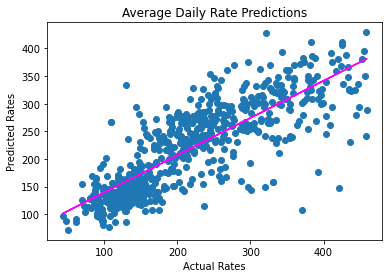

In [12]:
# PreProcess and Train a model
# Define preprocessing for numeric columns (scale them)
numeric_features = [1,2,3,4,6,7,8,9,10]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
# Ordinal encode True/False columns and Hot encode Property Type
categorical_features_hotencode = [0]
categorical_transformer_hotencode = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features_ordinal = [5,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
                               30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,
                               50,51,52,53,54,55,56,57,58]
categorical_transformer_ordinal = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=3))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer_hotencode, categorical_features_hotencode),
        ('cat2', categorical_transformer_ordinal, categorical_features_ordinal)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(x_train, (y_train))

# Get predictions
predictions = model.predict(x_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
r2adjusted = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
print("R2 Adjusted:", r2adjusted)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Rates')
plt.ylabel('Predicted Rates')
plt.title('Average Daily Rate Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()


67% R2 score is not perfect but not bad either (see downsides of this model at the beginning of the notebook). We'll go ahead and save the model as a pickle file for reuse and testing with fake data later.


In [ ]:
# Save the model as a pickle file
filename = './rentals.pkl'
joblib.dump(model, filename)

In [13]:
# Test my model with fake properties
# Assume high ratings, good customer service, most amenities, no pets
mymodel = joblib.load("rentals.pkl")

props = np.array([["condo",2,2,4,100,False,0,0,10,0.5,0.5,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False],
                  ["condo",2,2,4,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["condo",3,2,6,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["villa",3,2,6,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["townhouse",2,2,4,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["house",3,2,6,100,False,0,0,10,0.5,0.5,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False,False,
                False,False,False,False,False,False,False,False,False,False],
                  ["house",3,2,6,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["house",5,4,10,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False],
                 ["house",6,4,12,100,False,0,0,10,0.5,0.5,True,True,False,True,
                False,False,True,True,False,True,True,True,True,True,True,
                False,True,True,True,True,True,True,True,False,True,False,True,
                True,True,False,False,True,False,False,True,True,True,True,
                True,False,True,True,True,True,True,True,True,False]])

result = mymodel.predict(props)

print("Recommended Daily Rental Rates:")
print("2/2 Condo - ${}" .format(np.round(result[0])) + " (no amenities)")
print("2/2 Condo - ${}" .format(np.round(result[1])) + " (all amenities)")
print("3/2 Condo - ${}" .format(np.round(result[2])))
print("3/2 Villa - ${}" .format(np.round(result[3])))
print("2/2 Townhouse - ${}" .format(np.round(result[4])))
print("3/2 House - ${}" .format(np.round(result[5])) + " (no amenities)")
print("3/2 House - ${}" .format(np.round(result[6])))
print("5/4 House - ${}" .format(np.round(result[7])))
print("6/4 House - ${}" .format(np.round(result[8])))

Recommended Daily Rental Rates:
2/2 Condo - $268.0 (no amenities)
2/2 Condo - $268.0 (all amenities)
3/2 Condo - $268.0
3/2 Villa - $270.0
2/2 Townhouse - $266.0
3/2 House - $264.0 (no amenities)
3/2 House - $264.0
5/4 House - $314.0
6/4 House - $340.0



As you can see from the fake data, the amenities do not affect the price at all in the model predictions. Property Type, bedroom/bathroom count, and number of guests allowed are what really move the price around and those three features appear to compete with each other (note a 2/2 townhouse with a higher rate than a 3/2 house). Despite these issues in our modeling, the predicted rental rates fall within the range of what we actually see in this market.
